In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from tqdm import tqdm_notebook

In [2]:
def custom_StandardScaler(x):
    res = (x - x.mean()) / x.std()
    return res

In [3]:
def MinMaxScaler(x):
    res = (x - x.min())/(x.max()-x.min())
    return res

In [120]:
def pipl(df1):
    df=df1.copy()
    df['count_subj']=df['physics']+df['biology']+df['chemistry']+df['english']+df['geography']+df['history']
#     df['m_lesson_price']=MinMaxScaler(df['lesson_price'])
#     df['m_mean_exam_points']=MinMaxScaler(df['mean_exam_points'])
    submis=pd.DataFrame(df['Id'])
    df=df.drop(['Id'],axis=1)
    
#     df=df.drop(['Id','qualification','age','lesson_price','mean_exam_points','physics','biology','chemistry','english','geography','history'],axis=1)
    df=pd.get_dummies(df)
    return df,submis

In [121]:
sns.set(rc={'figure.figsize':(15,7)})

In [122]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
subm=pd.read_csv('submission_example.csv')

In [123]:
train.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [124]:
train.mean_exam_points.max()

100.0

In [125]:
train.lesson_price.value_counts()

1450.0    677
1500.0    639
1200.0    614
2200.0    547
1350.0    535
         ... 
200.0       2
3700.0      2
3950.0      1
3650.0      1
450.0       1
Name: lesson_price, Length: 71, dtype: int64

In [126]:
df.corr()

,years_of_experience,count_subj,m_lesson_price,m_mean_exam_points
years_of_experience,1.000000,0.013543,0.258408,0.213020
count_subj,0.013543,1.000000,0.018638,0.166927
m_lesson_price,0.258408,0.018638,1.000000,0.728596
m_mean_exam_points,0.213020,0.166927,0.728596,1.000000


In [134]:
tr=train.drop(['biology','chemistry','english','geography','history'],axis=1)

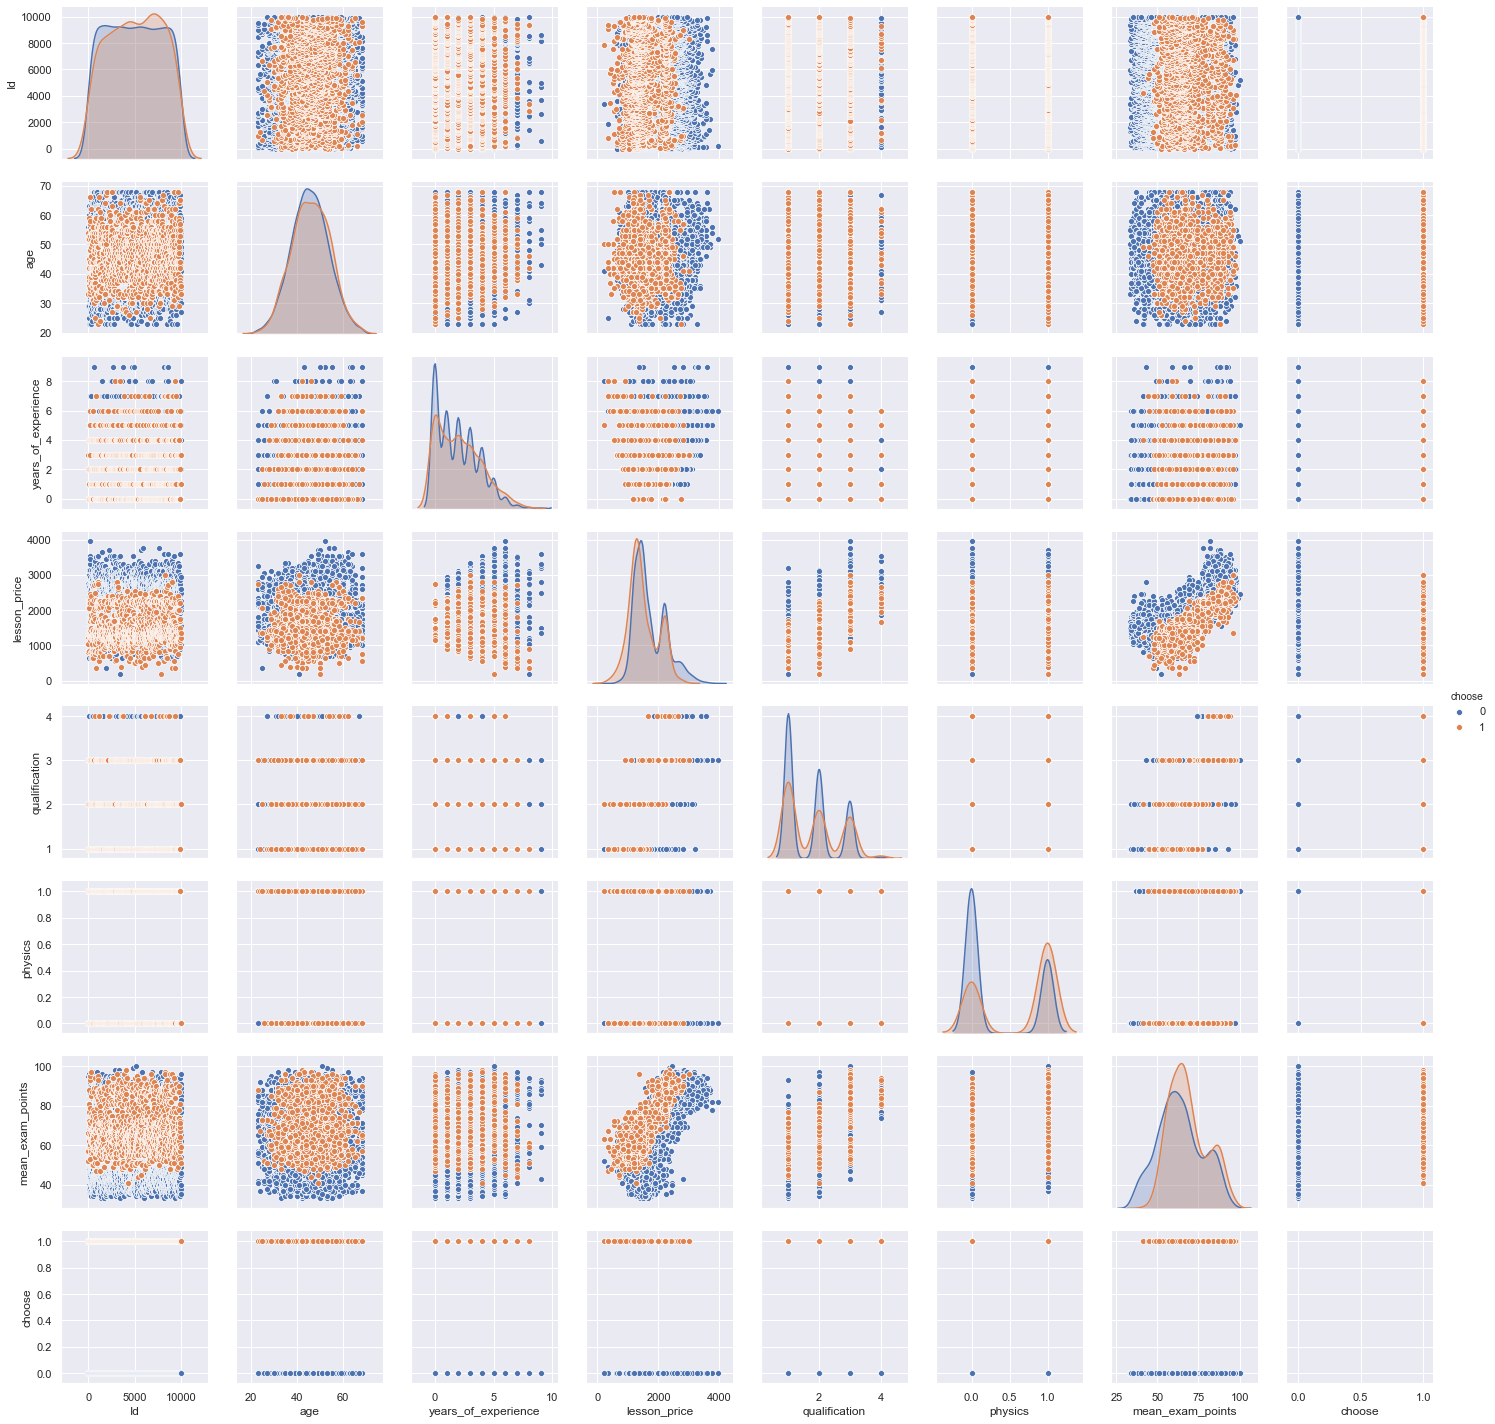

In [135]:
sns.pairplot(tr,hue='choose')

In [152]:
df2=tr.groupby(['choose','mean_exam_points','lesson_price'],as_index=False)\
.aggregate({'Id':'count'})

In [153]:
df2.to_csv('data_gr.csv',index=False)

In [137]:
tr.columns

Index(['Id', 'age', 'years_of_experience', 'lesson_price', 'qualification',
       'physics', 'mean_exam_points', 'choose'],
      dtype='object')

In [128]:
df,submis=train.pipe(pipl)
df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose,count_subj
0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0,0.0
1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1,3.0
2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0,1.0
3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1,0.0
4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0,1.0


In [27]:
# df['feat']=df['m_lesson_price']*df['m_mean_exam_points']
df['delim']=df['m_lesson_price']/df['m_mean_exam_points']

df.drop(['m_lesson_price','m_mean_exam_points'],axis=1,inplace=True)

In [92]:
df.corr()

,years_of_experience,choose,count_subj,m_lesson_price,m_mean_exam_points
years_of_experience,1.000000,0.029010,0.013856,0.253459,0.208089
choose,0.029010,1.000000,0.207977,-0.134013,0.109409
count_subj,0.013856,0.207977,1.000000,0.016253,0.161764
m_lesson_price,0.253459,-0.134013,0.016253,1.000000,0.729215
m_mean_exam_points,0.208089,0.109409,0.161764,0.729215,1.000000


In [129]:
X=df.drop('choose',axis=1)
y=df.choose

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [33]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [34]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [35]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [36]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [37]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [76]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [39]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [93]:
def build_tree(data, labels, tree_d =1, max_d=10):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    if tree_d>=max_d:
        return Leaf(data, labels)
    tree_d+=1
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,tree_d, max_d)
    false_branch = build_tree(false_data, false_labels,tree_d, max_d)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [40]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [41]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [42]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [43]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [44]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [45]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [46]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [47]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [48]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [49]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

***Вариант со случайным лесом***

In [50]:
train_data=X_train.to_numpy()
train_labels=y_train.to_numpy()
test_data=X_test.to_numpy()
test_labels=y_test.to_numpy()
n_trees=50
# for n_trees in tqdm_notebook(range(1,2)):

In [51]:
%%time
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 3h 33min 5s


In [52]:
train_answers = tree_vote(my_forest_1, train_data)
test_answers = tree_vote(my_forest_1, test_data)

In [53]:
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 91.700


In [54]:
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 88.900


In [59]:
df,submis=test.pipe(pipl)
df.head()

,age,years_of_experience,qualification,count_subj,m_lesson_price,m_mean_exam_points
0,32.0,2.0,3.0,0.0,0.657534,0.878788
1,35.0,6.0,2.0,2.0,0.410959,0.590909
2,44.0,2.0,1.0,0.0,0.246575,0.196970
3,44.0,4.0,3.0,1.0,0.726027,0.909091
4,38.0,3.0,2.0,1.0,0.301370,0.393939


In [56]:
test_data=df.to_numpy()
pred_answers = tree_vote(my_forest_1, test_data)

In [57]:
sub=pd.DataFrame(pred_answers,columns={'choose':pred_answers})
submision=pd.concat([submis,sub],axis=1,names=['Id','choose'])

submision.to_csv('submission.csv',sep=',',index=False)

In [58]:
submision.head(15)

,Id,choose
0,10000,0.0
1,10001,1.0
2,10002,1.0
3,10003,0.0
4,10004,1.0
5,10005,1.0
6,10006,0.0
7,10007,1.0
8,10008,0.0
9,10009,1.0


***Вариант с деревом***

In [94]:
%%time
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

Wall time: 3min 3s


In [95]:
# Получим ответы для обучающей выборки 
train_answers = predict(X_train.to_numpy(), my_tree)

In [96]:
# И получим ответы для тестовой выборки
answers = predict(X_test.to_numpy(), my_tree)

In [97]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(y_train.to_numpy(), train_answers)
train_accuracy

91.18571428571428

In [98]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(y_test.to_numpy(), answers)
test_accuracy

88.56666666666668

In [99]:
df,submis=test.pipe(pipl)
df.head()

,years_of_experience,count_subj,m_lesson_price,m_mean_exam_points
0,2.0,0.0,0.657534,0.878788
1,6.0,2.0,0.410959,0.590909
2,2.0,0.0,0.246575,0.196970
3,4.0,1.0,0.726027,0.909091
4,3.0,1.0,0.301370,0.393939


In [102]:
pred_answers = predict(df.to_numpy(), my_tree)

IndexError: index 4 is out of bounds for axis 0 with size 4

In [85]:
sub=pd.DataFrame(pred_answers,columns={'choose':pred_answers})
submision=pd.concat([submis,sub],axis=1,names=['Id','choose'])

submision.to_csv('submission.csv',sep=',',index=False)

In [86]:
submision.head()

,Id,choose
0,10000,0
1,10001,1
2,10002,0
3,10003,0
4,10004,1


In [ ]:
subm.head()

IndexError: index 4 is out of bounds for axis 0 with size 2

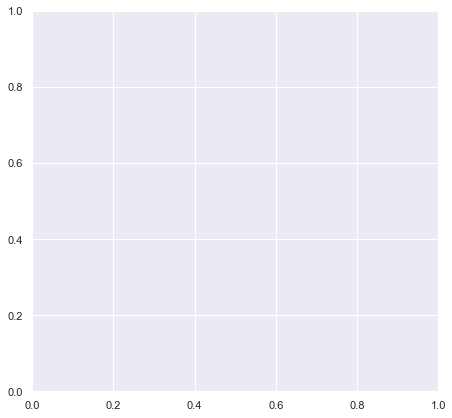

In [70]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c 
            = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}');

***Адаптивный бустинг***

In [60]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

In [61]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

In [62]:
N = 50

models = adaboost(X_train, y_train, N)

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
q=X_train.to_numpy() 
w=y_train.to_numpy()

In [ ]:

my_tree = build_tree(q,w)

In [ ]:
max_depth = 3
eta = 0.1
df=pd.DataFrame()
for n in range(1, 21):
    coefs = [1]*n
    trees, train_errors_, test_errors_ = gb_fit(n, 3, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    df_temp=pd.DataFrame({'n_trees':[n],'train_erors':[mean_squared_error(y_train, train_prediction)],'test_errors':[mean_squared_error(y_test, test_prediction)]})
    df=df.append(df_temp)